Goal of this notebook:
    - Benchmark both ways of determining connections between vertices at a time:
        - Create a method to benchmark both ways by entering a number of vertices and edges, setting up connections, and then timing the queries on a range of times and iterations.

In [33]:
# Jupyter notebook needs this or else it will crash
import nest_asyncio
nest_asyncio.apply()

from gremlin_python import statics
from gremlin_python.structure.graph import Graph
from gremlin_python.process.graph_traversal import __
from gremlin_python.driver.driver_remote_connection import DriverRemoteConnection
from gremlin_python.process.traversal import P # NEW!!! Import predicates (gt, gte, lt, lte, etc.)
from gremlin_python.process.traversal import Cardinality # NEW!!! Import Cardinality such as list_, set_ and single.

# Instantiate a Gremlin Graph
graph = Graph()

# Connect to the server, instantiate traversal of graph.
g = graph.traversal().withRemote(DriverRemoteConnection('ws://localhost:8182/gremlin','g'))

# Get the vertices of the graph as a list, and print them.

print(g.V().toList())

[v[3551384], v[1716232], v[1831000], v[1777888], v[44761280], v[44826816], v[3567768], v[1790176], v[1913048], v[1781984], v[1978448], v[3543192], v[3575960], v[1917144], v[44822720], v[1818696], v[1839192], v[44757184], v[1822808], v[44798144], v[44814528], v[44789952], v[44765376], v[1974352], v[44810432], v[1847368], v[44818624], v[44777664], v[3596440], v[1810520], v[1892568], v[1962064], v[1908952], v[3559576], v[2003024], v[1843288], v[1859656], v[1765600], v[1884376], v[1839176], v[1867848], v[1835096], v[1904856], v[1724424], v[1872088], v[1835080], v[3600536], v[44748992], v[3584152], v[1773792], v[44794048], v[1880280], v[3563672], v[3535000], v[1818712], v[1786080], v[1806424], v[44773568], v[3592344], v[3539096], v[3555480], v[44785856], v[1851464], v[1998928], v[1990736], v[44753088], v[1982544], v[3588248], v[1888472], v[3580056], v[44806336], v[1876184], v[1720328], v[1826888], v[44835008], v[1900760], v[1728520], v[1896664], v[1994832], v[44781760], v[44839104], v[18269

# METHOD 1

In [35]:
def connected_1(name1: str, name2: str, time: float) -> bool:
    """
    Given two vertices labelled with <name1> and <name2>, determine whether they were connected at time <time>. 
    Do so by sending a Gremlin query to determine whether there exists an edge between the 
    two vertices such that <time> falls in between their "start_time" and "end_time" parameters.
    TODO: Add sphinx documentation if this will be implemented into the actual Python library.
    """

    # Get the vertices associated with the names
    # v1, v2 = g.V().has('name', name1).next(), g.V().has('name', name2).next()

    # Return whether there are edges that:
    #   - connect v1 and v2, 
    #   - labelled 'connection',
    #   - have a start time that is less than or equal to <time>
    #   - either do not have an end time or have an end time that is greater than or equal to <time>
    return g.V().has('name', name1).bothE('connection').as_('e').bothV().has('name', name2).select('e').and_(
            __.has('start', P.lte(time)),   # want start time to be less than or equal to <time>
            __.or_(
                __.hasNot('end'),           # end time doesn't have to exist 
                __.has('end', P.gt(time))  # OR end time must be greater than <time>
            )
        ).count().next() > 0

In [37]:
def set_connection_1(name1: str, name2: str, time: float, connection: bool) -> None:
    """
    Given two vertices labelled with <name1> and <name2>, create a new connection or terminate their existing connection, based on the value of <bool>. Label with time <time>.

    TODO: Add sphinx documentation if this will be implemented into the actual Python library.
    """

    if connection:
        if not connected_1(name1, name2, time):
            # Get the vertices associated with the names
            v1, v2 = g.V().has('name', name1).next(), g.V().has('name', name2).next()

            # Add an edge labelled 'connection' with a start time of <time>
            g.V(v1).addE('connection').from_(v1).to(v2).property('start', time).iterate()

    else:

        # Get the vertices associated with the names
        v1, v2 = g.V().has('name', name1).next(), g.V().has('name', name2).next()

        # For all edges between v1 and v2 labelled 'connection' (there should only be one) that do not have an 'end' property, create an end property of <time>.
        g.V(v1).bothE('connection').filter(__.bothV().is_(v2)).hasNot('end').property('end', time).iterate()

# METHOD 2

In [39]:
def get_next_smallest_index(val, lst) -> int:
    """
    Given a sorted list lst in increasing order and val where val is of the same type as all elements in lst, 
    do a binary search and return the lower bound on the index (if the exact value is not found).
    """

    l, r = 0, len(lst) - 1

    while l <= r:
        mid = l + (r - l) // 2 
        if val > lst[mid]:
            l = mid + 1
        elif val < lst[mid]:
            r = mid - 1
        else:
            return mid
    return l - 1

# lst = [1, 3, 5, 7]
# for i in range(10):
#     print(i, lst[get_next_smallest_index(i, lst)])


In [41]:
def connected_2(name1: str, name2: str, time: float) -> bool:
    """
    Given two vertices labelled with <name1> and <name2>, determine whether they were connected at time <time>.
    Do so by sending a Gremlin query to find an edge labelled 'connected' between the two vertices. If one exists, get its "log" of changes to connections (which is just a list), and do a binary search to determine whether at <time>, the edge was active.
    """

    # Get the vertices associated with the names

    # REMOVE THIS LINE: it is inefficient, just find the vertices in the same query as getting the list.
    # v1, v2 = g.V().has('name', name1).next(), g.V().has('name', name2).next()

    # Get the "connection log" list of the edge that connects v1 and v2. If no edge exists, this should be an empty list.
    # The list should be of the format [[t, c], [t, c], ..., [t, c]], where t is the time of the change and c represents whether
    # the element was connected or disconnected at the time.

    # connections_list = g.V(v1).bothE('connection').filter(__.bothV().is_(v2)).values('connection_log').toList()

    connections_list = g.V().has('name', name1).bothE('connection').as_('e').bothV().has('name', name2).select('e').values('connection_log').toList()

    if len(connections_list) == 0:
        return False
    else:
        connections = connections_list[0]

        # How long each segment of the string is (1 for C, 10 for the Ts)
        n = 11

        # Get a list of the times of the connections
        times = [int(connections[i + 1: i + n]) for i in range(0, len(connections), n)]

        index = get_next_smallest_index(time, times)

        # print(connections, index)

        if index == -1:
            return False
        else:
            return bool(int(connections[index * n]))

In [43]:
def set_connection_2(name1: str, name2: str, time: float, connection: bool) -> None:
    """
    Given two vertices labelled with <name1> and <name2>, either add a new entry to the connection log of the 'connection' edge connecting the two vertices, or create a new edge if such an edge does not already exist.
    
    Preconditions:
         - time is greater than the times of all previous connections!

    TODO: Add sphinx documentation if this will be implemented into the actual Python library.
    """

    # This prevents multiple entries of the same type.
    if connection != connected_2(name1, name2, time):

        # Get the vertices associated with the names
        v1, v2 = g.V().has('name', name1).next(), g.V().has('name', name2).next()

        # this is either an empty list or a list containing one string
        entry_list = g.V(v1).bothE('connection').filter(__.bothV().is_(v2)).values('connection_log').toList()

        if len(entry_list) == 0:
            prev_entry = ""
        else:
            prev_entry = entry_list[0]

        # Append CTTTTTTTTTT to the previous log entry
        entry = prev_entry + str(int(connection)) + str(int(time)).zfill(10)

        g.V(v1).bothE('connection').filter(__.bothV().is_(v2)).fold().coalesce(
            __.unfold(), 
            __.addE('connection').from_(v1).to(v2)
        ).property('connection_log', entry).iterate()
        

# BENCHMARK SETUP

In [44]:
def clear_graph() -> None:
    """
    Drop the vertices and edges of the graph.
    """
    g.V().drop().iterate()
    g.E().drop().iterate()

In [45]:
def populate_vertices(vertices: list) -> None:
    """
    For each element of <vertices>, add a vertex to the graph with that name.
    """

    for name in vertices:
        g.addV().property('name', name).iterate()

In [46]:
def populate_connections_1(connections: list) -> None:
    """
    Using method 1, populate the connections of the vertices in the graph.

    connections should be a list containing tuples of the type
    ((name1, name2), (time, connected)) where name1 and name2 are names of existing vertices in the graph, and the list is sorted by time in increasing order.
    """

    for ((name1, name2), (time, connected)) in connections:
        set_connection_1(name1=name1, name2=name2, time=time, connection=connected)

In [47]:
def setup_method_1(vertices: list, connections: list) -> None:
    """
    Using method 1, clear the graph, populate the vertices, and populate the connections.
    """

    clear_graph()
    populate_vertices(vertices)
    populate_connections_1(connections)

In [48]:
def populate_connections_2(connections: list) -> None:
    """
    Using method 2, populate the connections of the vertices in the graph.

    connections should be a list containing tuples of the type
    ((name1, name2), (time, connected)) where name1 and name2 are names of existing vertices in the graph, and the list is sorted by time in increasing order.
    """

    for ((name1, name2), (time, connected)) in connections:
        set_connection_2(name1=name1, name2=name2, time=time, connection=connected)

In [49]:
def setup_method_2(vertices: list, connections: list) -> None:
    """
    Using method 2, clear the graph, populate the vertices, and populate the connections.
    """

    clear_graph()
    populate_vertices(vertices)
    populate_connections_2(connections)

# BENCHMARKS

In [50]:
import itertools
import random
import datetime

def benchmark(vertices_count: int, connections_count: int, calls_count_list: list) -> any:
    """
    Pregenerate lists of connections between the vertices, then test both methods using these lists.

    Return the setup time, and a list of query times for each of the call counts for each method in a tuple.
    """

    # print(f"\n\nBenchmarking both methods with {vertices_count} vertices, {connections_count} connections, and {calls_count} calls")

    vertices = ["v" + str(i) for i in range(vertices_count)]

    combinations = list(itertools.combinations(vertices, 2))

    # Remember what the last connection status was for each combination of vertices.
    last_connections = {comb: (0, False) for comb in combinations}

    connections = []

    time_min = -1
    time_max = 0

    for _ in range(connections_count):
        
        # Combination 
        comb = random.choice(combinations)

        # Last connection for this combination
        last = last_connections[comb]

        # Times will be in intervals of 2 (arbitrary)
        time = last[0] + 2

        if time > time_max:
            time_max = time

        # Alternate between connected and disconnected
        connected = not last[1]

        connection = (time, connected)

        last_connections[comb] = connection

        connections.append((comb, connection))

    # Test method 1

    # print("\n--------")
    # print("METHOD 1")
    # print("--------")

    calls = [(random.choice(combinations), random.randint(time_min, time_max + 1)) for _ in range(max(calls_count_list))]

    query_times_1, query_times_2 = [], []

    # Setup
    now = datetime.datetime.now()

    setup_method_1(vertices=vertices, connections=connections)

    setup_time_1 = (datetime.datetime.now() - now).total_seconds()


    # Queries

    for calls_count in calls_count_list:

        now = datetime.datetime.now()
        
        for i in range(calls_count):
            ((name1, name2), time) = calls[i]
            connected_1(name1, name2, time)

        query_time_1 = (datetime.datetime.now() - now).total_seconds()
        query_times_1.append(query_time_1)


    # Test method 2

    # Setup
    now = datetime.datetime.now()

    setup_method_2(vertices=vertices, connections=connections)

    setup_time_2 = (datetime.datetime.now() - now).total_seconds()


    # Queries
    for calls_count in calls_count_list:

        now = datetime.datetime.now()
        
        for i in range(calls_count):
            ((name1, name2), time) = calls[i]
            connected_2(name1, name2, time)

        query_time_2 = (datetime.datetime.now() - now).total_seconds()
        query_times_2.append(query_time_2)


    return ((setup_time_1, query_times_1), (setup_time_2, query_times_2))



In [51]:
benchmark(vertices_count=10, connections_count=10, calls_count_list=[10, 20, 30])

((1.278468, [0.17772, 0.354889, 0.519953]),
 (0.835835, [0.179792, 0.343755, 0.513693]))

In [54]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def plot(vertices_count: int, connections_count: int, calls_list: list) -> None:
    """
    For each calls count in calls_list, run benchmark and then plot the results.
    """

    ((setup_time_1, query_times_1), (setup_time_2, query_times_2)) = benchmark(
                                                                                vertices_count=vertices_count, 
                                                                                connections_count=connections_count, 
                                                                                calls_count_list=calls_list)
    query_times_1 = np.asarray(query_times_1)
    query_times_2 = np.asarray(query_times_2)
    calls_list = np.asarray(calls_list)


    plt.plot(calls_list, query_times_1 / calls_list, label="Method 1 Query Times")
    plt.plot(calls_list, query_times_2 / calls_list, label="Method 2 Query Times")
    plt.title(f"{vertices_count} vertices, {connections_count} connections")
    plt.xlabel("Number of Calls")
    plt.ylabel("Average Query Time (s)")
    plt.legend()
    plt.show()



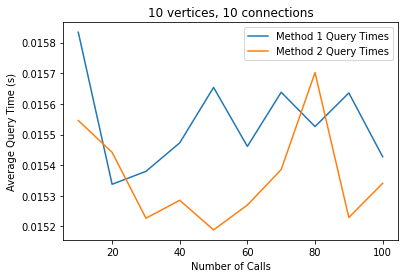

In [36]:
plot(vertices_count=10, connections_count=10, calls_list=list(range(10, 110, 10)))

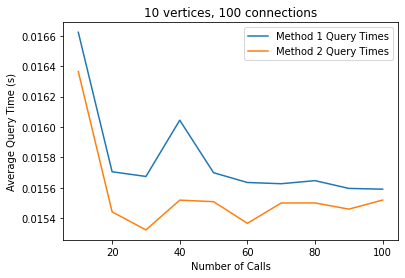

In [38]:
plot(vertices_count=10, connections_count=100, calls_list=list(range(10, 110, 10)))

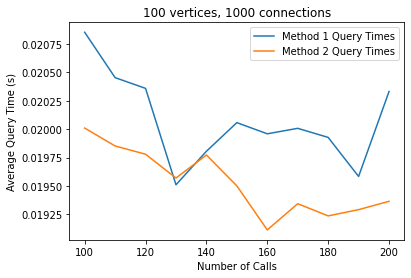

That took 210.232188 seconds!


In [40]:
now = datetime.datetime.now()

plot(vertices_count=100, connections_count=1000, calls_list=list(range(100, 210, 10)))

print("That took", (datetime.datetime.now() - now).total_seconds(), "seconds!")